In [1]:
from re import split
from fastai import *
from fastai.vision import *
from fastai.vision.all import *
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
torch.cuda.device(0)
torch.cuda.get_device_name(0)

'NVIDIA GeForce GTX 1660'

In [3]:
print(torch.cuda.is_available())

True


In [4]:
! nvcc -V

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


In [5]:
import os
# os.path.expanduser('qiaolinhan')
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [6]:
path = Path('/home/qiaolinhan/dev/datasets/kittiseg/training')
path_img = path/'image_2/'

path_label = path/'semantic_rgb/'
# codes = ['Road', 'Person', 'Car', 'Bike', 'Pets', 'Light', 'Vegetation', 'Sky', 'Cloud', 'Bound', 'Sign', 'Pole']
codes = ['Road', 'Sidewalk', 'Building', 'Wall', 'Fence', 
         'Pole', 'Traffic light', 'Trafic sign', 'Vegetation',
         'Terrain', 'Sky', 'Person', 'Rider', 'Car', 'Track', 'Bus',
         'Train', 'Motorcycle', 'Bicycle', 'Unlabelled']

In [7]:
fnames = get_image_files(path_img)
print(fnames[0])

/home/qiaolinhan/dev/datasets/kittiseg/training/image_2/000054_10.png


In [8]:
lbl_names = get_image_files(path_label)
print(lbl_names[0])

/home/qiaolinhan/dev/datasets/kittiseg/training/semantic_rgb/000054_10.png


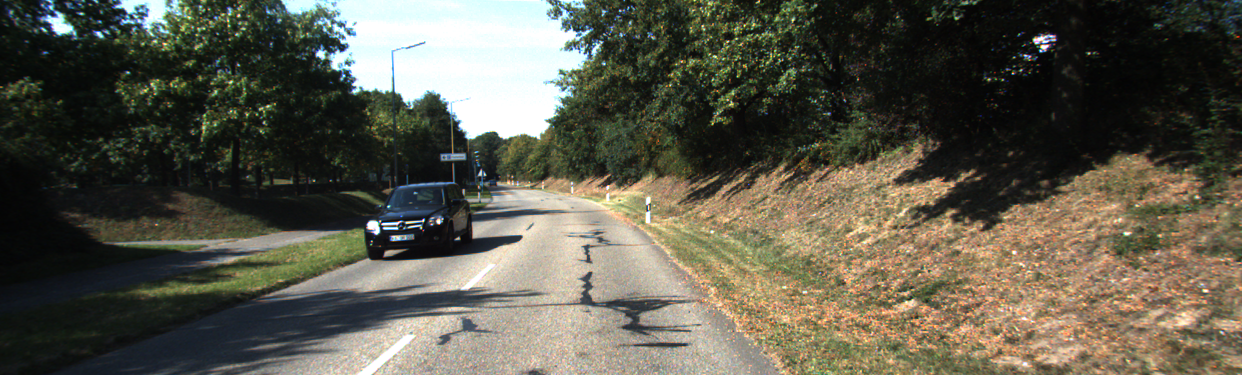

In [9]:
img = Image.open(fnames[0])
img.show()

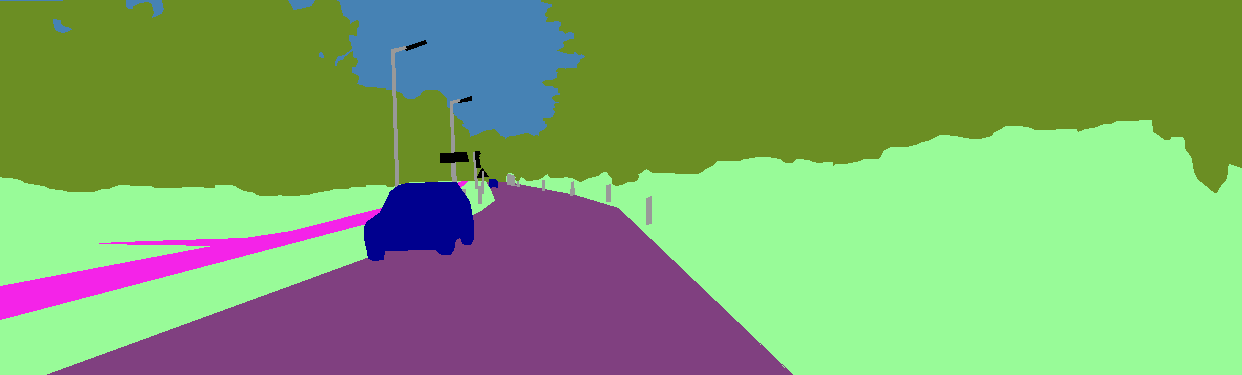

In [10]:
img = Image.open(lbl_names[0])
img.show()

In [11]:
get_y_fn = lambda x: path_label/f'{x.name}'
defaults.use_cuda = True

In [12]:
dls = SegmentationDataLoaders.from_label_func(
    path_img,
    bs = 2,
    fnames = fnames,
    label_func = get_y_fn,
    codes = codes,
    item_tfms = [Resize((400, 400))],
    batch_tfms = [Normalize.from_stats(*imagenet_stats)],
)

In [13]:
name2id = {v:k for k, v in enumerate(codes)}
# void_code = name2id['Void']

def acc_smoke(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    # mask = target
    return (input.argmax(dim = 1)[mask]==target[mask]).float().mean()

metrics = acc_smoke

In [14]:
learn = unet_learner(dls, models.resnet34, metrics = metrics,
                    self_attention=True)

In [15]:
device = 'gpu'
learn.model.to(device)

DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05

In [16]:
# learn.model

In [17]:
learn.lr_find(stop_div=False, num_it=200)

/opt/conda/conda-bld/pytorch_1607370117127/work/aten/src/THCUNN/ClassNLLCriterion.cu:108: cunn_ClassNLLCriterion_updateOutput_kernel: block: [0,0,0], thread: [0,0,0] Assertion `t >= 0 && t < n_classes` failed.
/opt/conda/conda-bld/pytorch_1607370117127/work/aten/src/THCUNN/ClassNLLCriterion.cu:108: cunn_ClassNLLCriterion_updateOutput_kernel: block: [0,0,0], thread: [1,0,0] Assertion `t >= 0 && t < n_classes` failed.
/opt/conda/conda-bld/pytorch_1607370117127/work/aten/src/THCUNN/ClassNLLCriterion.cu:108: cunn_ClassNLLCriterion_updateOutput_kernel: block: [0,0,0], thread: [2,0,0] Assertion `t >= 0 && t < n_classes` failed.
/opt/conda/conda-bld/pytorch_1607370117127/work/aten/src/THCUNN/ClassNLLCriterion.cu:108: cunn_ClassNLLCriterion_updateOutput_kernel: block: [0,0,0], thread: [3,0,0] Assertion `t >= 0 && t < n_classes` failed.
/opt/conda/conda-bld/pytorch_1607370117127/work/aten/src/THCUNN/ClassNLLCriterion.cu:108: cunn_ClassNLLCriterion_updateOutput_kernel: block: [0,0,0], thread: [4

RuntimeError: cuda runtime error (710) : device-side assert triggered at /opt/conda/conda-bld/pytorch_1607370117127/work/aten/src/THCUNN/generic/ClassNLLCriterion.cu:115

In [18]:
lr = 9.12e-5
learn.fit_one_cycle(13, slice(lr))

epoch,train_loss,valid_loss,acc_smoke,time


RuntimeError: CUDA error: device-side assert triggered

In [ ]:
learn.recorder.plot_loss(skip_start=0, with_valid=True)

In [ ]:
learn.save('stage-1')
learn.load('stage-1')

In [ ]:
learn.unfreeze()
learn.lr_find()

In [ ]:
lr_max = 2.51e-5

In [ ]:
learn.fit_one_cycle(4, lr_max)

In [ ]:
learn.recorder.plot_loss(skip_start=0, with_valid=True)

In [ ]:
# learn.show_results()
# learn.save('attunet')

In [ ]:
# learn.show_results()

In [ ]:
learn.show_results()

In [ ]:
learn.show_results()

In [ ]:
learn.show_results()

In [ ]:
learn.show_results()
learn.save('alunet')

In [ ]:
learn.show_results()

In [ ]:
learn.show_results()

In [ ]:
learn.show_results()

In [ ]:
img = Image.open('datas/database/000200.jpg').resize((255, 255))
img.show()

In [ ]:
img = PILImage(img)

In [ ]:
learn.load('alunet')
# learn.load('attunet')

In [ ]:
prediction_mask = learn.predict(img)
seg_map = prediction_mask[0]
torch.Tensor.ndim = property(lambda self: len(self.shape))
plt.imshow(seg_map)